In [1]:
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

__Cascade Classifiers 로드__

In [2]:
face_cascade = cv2.CascadeClassifier('haarcascade_frontface.xml')
eye_cascade = cv2.CascadeClassifier('haarcascade_eye.xml')
glass_cascade = cv2.CascadeClassifier('haarcascade_eye_tree_eyeglasses.xml')

__advanced_eye_detect 함수 정의__

In [44]:
def advanced_eye_detect(img,cascade,info):
    
    ret_val=[]
    
    img_gray =  cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    faces = face_cascade.detectMultiScale(img_gray)
    
    print(f'1번함수 : {len(faces)}')
    
    if len(faces)!=1:
        return ret_val
    
    for (x,y,w,h) in faces:
        roi_gray = img_gray[y:y+h, x:x+w]
        eyes =cascade.detectMultiScale(roi_gray,1.1,4)
    
    if not (len(eyes)==2):    
        if info == 'normal':
            return advanced_eye_detect(img,glass_cascade,'glasses')
        elif info == 'glasses':
            return ret_val
        
    ret_val = eyes
    return ret_val

__get_rotated_image 함수 정의__

In [4]:
def get_rotated_image(img,eyes):
    
    eye_1 , eye_2 = eyes

    if eye_1[0] < eye_2[0]:
        left_eye = eye_1
        right_eye = eye_2
    else:
        left_eye = eye_2
        right_eye = eye_1
        
    left_eye_center = (int(left_eye[0] + (left_eye[2] / 2)), int(left_eye[1] + (left_eye[3] / 2)))
    right_eye_center = (int(right_eye[0] + (right_eye[2]/2)), int(right_eye[1] + (right_eye[3]/2)))
    
    left_eye_x , left_eye_y = left_eye_center 
    right_eye_x , right_eye_y = right_eye_center

    
    delta_x = right_eye_x - left_eye_x
    delta_y = right_eye_y - left_eye_y
    
    angle=np.arctan(delta_y/delta_x)
    angle = (angle * 180) / np.pi
    
    h, w = img.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, (angle), 1.0)
    rotated_img = cv2.warpAffine(img, M, (w, h))
  
    return rotated_img

__calculate_rotated_eyes 함수 정의__

In [38]:
def calculate_rotated_eyes(rotated_img,cascade,info):

    ret_val=[]
    
    rotated_gray = cv2.cvtColor(rotated_img, cv2.COLOR_BGR2GRAY)
    
    faces = face_cascade.detectMultiScale(rotated_gray, 1.1, 4)
    print(faces)
    print(rotated_gray.shape)
    
    if len(faces)!=1:
        return False,ret_val
    
    for (x,y,w,h) in faces:

        black=np.zeros(rotated_gray.shape,dtype='uint8')
        black[y:y+h, x:x+w]=rotated_gray[y:y+h, x:x+w]

        rotated_eyes =cascade.detectMultiScale(black,1.1,4)    
    
    plt.imshow(black)
    
    if not (len(rotated_eyes==2)):    
        if info == 'normal':
            return calculate_rotated_eyes(rotated_img,glass_cascade,'glasses')
        elif info == 'glasses':
            return False , ret_val
        
    print(rotated_eyes)
    
    ret_val = rotated_eyes
    
    return True,ret_val

__extract_facial_mask_area 함수 정의__

In [6]:
def extract_facial_mask_area(rotated_img,rotated_eyes):
    
    eye_1 , eye_2 = rotated_eyes

    if eye_1[0] < eye_2[0]:
        left_eye = eye_1
        right_eye = eye_2
    else:
        left_eye = eye_2
        right_eye = eye_1
    
    left_eye_center = (int(left_eye[0] + (left_eye[2] / 2)), int(left_eye[1] + (left_eye[3] / 2)))
    right_eye_center = (int(right_eye[0] + (right_eye[2]/2)), int(right_eye[1] + (right_eye[3]/2)))
    
    left_eye_x , left_eye_y = left_eye_center 
    right_eye_x , right_eye_y = right_eye_center
    
    delta_x = right_eye_x - left_eye_x
    delta_y = right_eye_y - left_eye_y
    
    L = np.sqrt(delta_x**2 + delta_y**2)
    xpad_L , xpad_R = int(0.6*L) , int(1.6*L)
    ypad_U , ypad_D = int(0.6*L) , int(1.8*L)
    
    ROI = rotated_img[left_eye_y-ypad_U:left_eye_y+ypad_D,left_eye_x-xpad_L:left_eye_x+xpad_R]
    ROI_resized = cv2.resize(ROI,(120,140))
    mask_area = ROI_resized[50:140,0:120]
    
    return mask_area

__메인 코드__

1번함수 : 1
[[83 37 40 40]
 [23 38 42 42]]
[[ 54  64 153 153]]
(256, 256)
[[140 103  39  39]
 [ 78 100  45  45]]
1번함수 : 1
[[98 46 41 41]
 [33 44 45 45]]
[[ 39  54 177 177]]
(256, 256)
[[ 72  98  45  45]
 [137 101  39  39]]
1번함수 : 1
[[87 33 44 44]
 [24 39 41 41]]
[[ 50  61 158 158]]
(256, 256)
[[139  98  46  46]
 [ 74  98  42  42]]
1번함수 : 1
1번함수 : 1
[]
00183.png
Detection Failed : not human or invalid image
1번함수 : 1
[[95 55 39 39]
 [32 44 50 50]]
[[ 42  51 178 178]]
(256, 256)
[[122 148  26  26]
 [136 100  38  38]
 [ 74  95  47  47]]
00184.png
처음에는 1개 검출 , 회전후에 face가 2개 이상 검출
1번함수 : 0
[]
00185.png
Detection Failed : not human or invalid image
1번함수 : 1
1번함수 : 1
[]
00186.png
Detection Failed : not human or invalid image
1번함수 : 1
[[32 40 30 30]
 [17 28 62 62]]
()
(256, 256)
00187.png
처음에는 1개 검출 , 회전후에 face가 2개 이상 검출
1번함수 : 1
[[85 37 42 42]
 [24 40 42 42]]
[[ 52  64 153 153]]
(256, 256)
[[ 76  99  42  42]
 [135  96  47  47]]
1번함수 : 1
[[24 47 42 42]
 [42 51 34 34]]
[[ 47  53 174 174]]
(256, 256

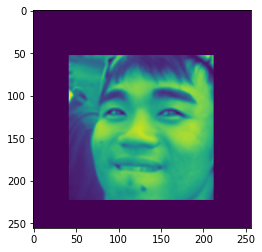

In [45]:
import os

#img_path = "전체 사진이 모여있는 폴더 경로명"
img_path = "C:/no_mask/no_mask/"

files = os.listdir(img_path)
image_files = [file for file in files if file.endswith(".png")]
mask_area=[]
for file in image_files:
    
    image=cv2.imread(img_path+file)
    
    w,h,c = image.shape
    
    #image = cv2.resize(image,(400,400))
    
    if image.shape[0]<400 or image.shape[1]<400 :
        w,h,c = image.shape
        image = cv2.resize(image,(h*2,w*2))
    
    eyes = advanced_eye_detect(image,eye_cascade,'normal')
    print(eyes)
    
    if not (len(eyes)==2):
        print(file)
        print('Detection Failed : not human or invalid image')
        continue
        
    rotated_image = get_rotated_image(image,eyes)
    valid,rotated_eyes = calculate_rotated_eyes(rotated_image,eye_cascade,'normal')
    
    if (not valid) or (not len(rotated_eyes)==2):
        print(file)
        print('처음에는 1개 검출 , 회전후에 face가 2개 이상 검출')
        continue

    current_mask_area = extract_facial_mask_area(rotated_image,rotated_eyes)
    mask_area.append(current_mask_area)
    
print(len(mask_area))

In [46]:
print(len(mask_area))

24


In [25]:
files

['rr.PNG']

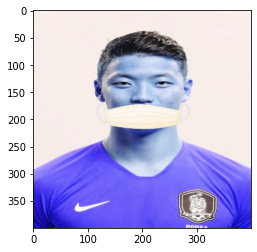

In [27]:
plt.imshow(image)

In [ ]:
plt.imshow(rotated_image)

In [ ]:
rotated_eyes

In [ ]:
plt.imshow(image)

In [ ]:
plt.imshow(mask_area[0])

In [ ]:
img=cv2.imread('C:/img_sample/1/sample1.jpg')
img2=cv2.resize(img,(400,800))

gray = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
gray.shape

In [ ]:
plt.imshow(gray)

In [ ]:
a=np.zeros((800, 400),dtype='uint8')
a.shape

__get_aligned_ROI 함수 정의__

In [ ]:
def get_aligned_ROI(img , eyes , early_stop=False):
    print(f'len : {len(eyes)}')
    eye_1 , eye_2 = eyes

    if eye_1[0] < eye_2[0]:
        left_eye = eye_1
        right_eye = eye_2
    else:
        left_eye = eye_2
        right_eye = eye_1
        
    left_eye_center = (int(left_eye[0] + (left_eye[2] / 2)), int(left_eye[1] + (left_eye[3] / 2)))
    right_eye_center = (int(right_eye[0] + (right_eye[2]/2)), int(right_eye[1] + (right_eye[3]/2)))
    
    left_eye_x , left_eye_y = left_eye_center 
    right_eye_x , right_eye_y = right_eye_center

    
    delta_x = right_eye_x - left_eye_x
    delta_y = right_eye_y - left_eye_y
    
    if early_stop:
        return left_eye_x , left_eye_y , np.sqrt(delta_x**2 + delta_y**2)
    
    angle=np.arctan(delta_y/delta_x)
    angle = (angle * 180) / np.pi
    
    h, w = img.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, (angle), 1.0)
    rotated_img = cv2.warpAffine(img, M, (w, h))
    
    rotated_eyes =eye_cascade.detectMultiScale(rotated_img,1.1,4)
    rotated_eyes
    
    
    
    for (x,y,w,h) in faces:
        roi_gray = gray[y:y+h, x:x+w]
        eyes =cascade.detectMultiScale(roi_gray,1.1,4)
    
    
    return rotated_eyes , rotated_img